In [ ]:
import glob
from skimage.io import imread
from skimage.color import gray2rgb
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model


from mlxtend.plotting import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
# dataset_path = '/content/Group_2.zip'

with ZipFile(dataset_path, 'r') as zip:
  zip.extractall()

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def alexnet_model(input_shape, number_of_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Layer 4
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Layer 5
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(number_of_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Load and preprocess the data
train_datagen = train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Group_2/train',
    target_size=(224, 224),  # Update the target size
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Group_2/test',
    target_size=(224, 224),  # Update the target size
    batch_size=32,
    class_mode='categorical'
)

# Build the model
input_shape = (224, 224, 3)
model = alexnet_model(input_shape, number_of_classes=len(train_generator.class_indices))



# Define the file path for saving the best model
checkpoint_filepath = 'alexnet_best_model.h5'

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1)

# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compile the model with the learning rate scheduler
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with ModelCheckpoint and EarlyStopping callbacks
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


# Load the best model based on validation accuracy
best_model = load_model(checkpoint_filepath)
model.summary()

Found 2164 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/60
68/68 [==============================] - ETA: 0s - loss: 90.0496 - accuracy: 0.5046
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to alexnet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 20s 142ms/step - loss: 90.0496 - accuracy: 0.5046 - val_loss: 87.7163 - val_accuracy: 0.2000
Epoch 2/60
68/68 [==============================] - ETA: 0s - loss: 84.7522 - accuracy: 0.5961
Epoch 2: val_accuracy did not improve from 0.20000
68/68 [==============================] - 5s 69ms/step - loss: 84.7522 - accuracy: 0.5961 - val_loss: 84.3178 - val_accuracy: 0.2000
Epoch 3/60
68/68 [==============================] - ETA: 0s - loss: 79.9736 - accuracy: 0.6132
Epoch 3: val_accuracy improved from 0.20000 to 0.24400, saving model to alexnet_best_model.h5
68/68 [==============================] - 9s 127ms/step - loss: 79.9736 - accuracy: 0.6132 - val_loss: 80.0117 - val_accuracy: 0.2440
Epoch 4/60
68/68 [==============================] - ETA: 0s - loss: 75.1942 - accuracy: 0.6696
Epoch 4: val_accuracy did not improve from 0.24400
68/68 [==============================] - 5s 69ms/step - loss: 75.1942 - accuracy: 0.6696 - val_loss: 75.0694 - val_accur

In [ ]:
predictions = best_model.predict(test_generator)

# You may want to convert the predictions to class labels if needed
y_pred = tf.argmax(predictions, axis=1)

# Evaluate the accuracy by comparing with true labels
y_test = test_generator.classes

# print(f"Predicted Classes: {y_pred}")
print(classification_report(y_test, y_pred, digits = 3))

8/8 [==============================] - 1s 100ms/step
              precision    recall  f1-score   support

           0      0.277     0.260     0.268        50
           1      0.286     0.280     0.283        50
           2      0.203     0.260     0.228        50
           3      0.143     0.180     0.159        50
           4      0.222     0.120     0.156        50

    accuracy                          0.220       250
   macro avg      0.226     0.220     0.219       250
weighted avg      0.226     0.220     0.219       250



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

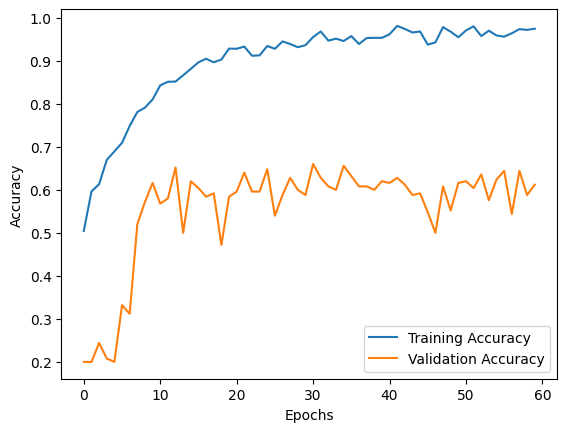

In [ ]:
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Best Model Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 [==============================] - 1s 91ms/step - loss: 10.8639 - accuracy: 0.6600
Best Model Test Accuracy: 66.00%
